## Evaluación de proyecto

### 1. Librerías

In [4]:
#!pip install numpy-financial

In [5]:
import numpy as np
import numpy_financial as npf
import pandas as pd
from ipywidgets import FloatSlider, interactive_output, VBox, Label
import seaborn as sns
import matplotlib.pyplot as plt
import random
from scipy.stats import norm
import statistics as stat

### 2. Archivo xlsx 

In [6]:
# Ruta del archivo Excel a utilizar
file = 'Flujo_de_fondos.xlsx'  

### 3. Flujo de Fondos 

Durante el proceso, se detectaron 2 tipos de datos:

    1. Datos que dependen de otras celdas, por ejemplo:
    
        I. El "Precio" (celda A4), donde el valor actual es el valor anterior ajustado por inflacion. 
        II. Los Impuestos (A12, A13, A14), se ajustan esencialmente, por los ingresos.
                
    2. Datos independientes, por ejemplo: "Amortizaciones y Depreciaciones" (celda A11)


Para todos estos se desarrollan las siguientes **funciones**

In [7]:
# Funcion 1:
def generate_data(min_value,   # Valor del anio 1.
                  year_range,  # Anios contemplados para el calculo del VAN y TIR. 
                  step = None, # Incrementos anuales, pueden ser en cantidades o porcentajes.
                  year_0=0,    # Valor del anio 0, en este caso, no se produce.
                  max_value=None,    # Capacidad maxima o limite maximo.  
                  is_quantity=False  # "False" = Incrementos porcentuales, "True" = Incrementos en cantidades.
                 ): 
    '''
    Funcion para generar los Precios, las Cantidades, y los Costos
    '''
    data_list = [year_0, min_value]
    if type(step) == list:
        for i in range(1, year_range):
            if is_quantity:
                data_i = data_list[i] + step[i-1]
            else:
                data_i = data_list[i] * step[i-1]

            if max_value is not None and data_i >= max_value:
                data_i = max_value

            data_list.append(data_i)
    else:
        try:
            for i in range(1, year_range):
                if is_quantity:
                    data_i = data_list[i] + step
                else:
                    data_i = data_list[i] * step

                if max_value is not None and data_i >= max_value:
                    data_i = max_value

                data_list.append(data_i)
        except:
            return 'Error in type step'

    return data_list


# Funcion 2:
def values_excel_data(file,  # Nombre del archivo Excel.
                      sheet, # Nombre de la hoja o Worksheet.
                      num_rows,  # Numero de filas.
                      skip_rows, # Numero de filas que se deben saltar u omitir.
                      whith_header = None, # Tiene encabezado? .
                      col_range = None     # Rango de columnas a seleccionar.
                     ):
    '''
    Funcion para generar los datos independientes:
        Amortizacion y Depreciacion, Inversion Inicial, Capital de trabajo, Prestamo y Pago de prestamo
    '''
    data_list = pd.read_excel(file, sheet_name= sheet, header= whith_header, skiprows=skip_rows, usecols=col_range , nrows=num_rows)
    return np.nan_to_num(np.array(data_list).flatten().tolist())


# Funcion 3:
def tax_data(percentage,    # Porcentaje, de 0 a 100.
             concept = list # lista de valores sobre el cual se aplica el procentaje.
            ):
    '''
    Funcion para generar los Impuestos
    '''
    tax_list = [(percentage/100)*concept[i] for i in range(len(concept))]
    tax_list = [x * (-1) for x in tax_list]
    return tax_list

A continuacion se **confecciona** el Flujo de Fondos utilizando las funciones anteriores.  

In [8]:
def cashflow_values(years, # Anios contemplados para el calculo del VAN y TIR. 
                    price, # Precio del anio 1.
                    quantity, # Cantidad del anio 1.
                    cost_product, # Costo de Produccion del anio 1.
                    cost_admin    # Costo de Administracion y Venta del anio 1.
                   ):  
    '''
    Elabora un diccionario de los conceptos y sus respectivos valores, 
    Utilizando las funciones 'generate_data' , 'values_excel_data' y 'tax_data'. 
    '''
    # Precio
    price_data = generate_data(min_value=price, step=1.025, year_range=years, is_quantity=False)

    # Cantidad
    quantity_data = generate_data(min_value=quantity, step=3000, year_range=years, max_value=2800000, is_quantity=True)

    # Total Ingresos
    income_data = [price_data[i] * quantity_data[i] for i in range(len(price_data))]

    # Costo de Produccion
    step_list = [income_data[i+2]/income_data[i+1] for i in range(len(income_data)-2)]
    cost_prod_data = (np.array(generate_data(min_value=cost_product, step=step_list, year_range=10, is_quantity=False))*-1).tolist()

    # Costo de administracion y venta
    cost_adm_data = (np.array(generate_data(min_value=cost_admin, step=1.025, year_range=10, is_quantity=False))*-1).tolist() 

    # Total Costos
    expense_data = [cost_prod_data[i] + cost_adm_data[i] for i in range(len(cost_adm_data))] 

    # Amortizaciones y Depreciaciones
    amort_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 15, col_range= range(1, 12))

    # Impuesto IIBB
    IIBB_data = tax_data(3.5, income_data)

    # Impuesto a las ganancias
    profits_data = tax_data(35, list(map(sum, zip(income_data, expense_data, [x * (-1) for x in amort_data]))))

    # Impuesto a la bebida
    drinks_data = tax_data(4, income_data)

    # Inversion inicial
    invert_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 16, col_range= range(1, 12))

    # Capital de Trabajo
    capital_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 17, col_range= range(1, 12))

    # Prestamo
    loan_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 18, col_range= range(1, 12))

    # Pago de prestamo
    loan_payment_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 19, col_range= range(1, 12))

    # Diccionario 
    dict_cash_flow = {
                'Total Ingresos': [price*quantity for price, quantity in zip(price_data, quantity_data)],
                'Total Costos'  : list(map(sum, zip(cost_prod_data, cost_adm_data))),
                'Amort/Depreciacion': amort_data,
                'Imp. IIBB'     : IIBB_data,
                'Imp.Ganancias' : profits_data,
                'Imp. Bebidas'  : drinks_data,
                'Inversion inicial'   : invert_data,
                'Capital de trabajo'  : capital_data,
                'Prestamo'            : loan_data,
                'Pago de prestamo'    : loan_payment_data
                }

    return dict_cash_flow

In [9]:
def accum_cash_flow (dictionary):
    '''
    Retorna un DataFrame del Flujo de Fondos Acumulado con los conceptos generados en 'cashflow_values'.
    '''
    amort_depreciacion = dictionary.pop('Amort/Depreciacion', 0)
    neto = [sum(x)  for x in zip(*dictionary.values())]
    

    accum = [neto[0],]
    for i in range(1,len(neto)):
        x = neto[i]+accum[i-1]
        accum.append(x)
    dictionary['Flujo de Fondos Acum.'] = accum 
    
    new_dict = dict(list(dictionary.items())[:2] +
                   [('Amort/Depreciacion', amort_depreciacion)] +
                   list(dictionary.items())[2:])
    
    return np.round(pd.DataFrame(new_dict).T,2)

In [10]:
cash_flow_dict = cashflow_values(years = 10, 
                                 price = 1.8, 
                                 quantity = 261000, 
                                 cost_product= 187184.96, 
                                 cost_admin = 24852.90)
accum_cash_flow (cash_flow_dict)

,0,1,2,3,4,5,6,7,8,9,10
Total Ingresos,0.00,469800.00,487080.00,504930.37,523368.84,542413.65,562083.60,582398.03,603376.89,625040.69,647410.56
Total Costos,0.00,-212037.86,-219544.15,-227293.22,-235292.54,-243549.76,-252072.79,-260869.75,-269949.01,-279319.19,-288989.17
Amort/Depreciacion,0.00,21779.90,21779.90,21779.90,21779.90,21779.90,21779.90,21779.90,21779.90,21779.90,21779.90
Imp. IIBB,-0.00,-16443.00,-17047.80,-17672.56,-18317.91,-18984.48,-19672.93,-20383.93,-21118.19,-21876.42,-22659.37
Imp.Ganancias,-0.00,-82593.78,-86014.58,-89550.04,-93203.74,-96979.40,-100880.82,-104911.93,-109076.79,-113379.56,-117824.52
Imp. Bebidas,-0.00,-18792.00,-19483.20,-20197.21,-20934.75,-21696.55,-22483.34,-23295.92,-24135.08,-25001.63,-25896.42
Inversion inicial,-399686.38,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Capital de trabajo,-60341.27,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Prestamo,139890.23,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Pago de prestamo,0.00,-50954.70,-50954.70,-50954.70,-50954.70,-50954.70,0.00,0.00,0.00,0.00,0.00


### 4. Rentabilidad del proyecto - VAN y TIR

**Calculadora del VAN y TIR** asociado a Flujo de Fondos

In [11]:
def TIR_VAN_calculator(price,    # Precio del anio 1.
                       quantity, # Cantidad del anio 1.
                       cost_product, # Costo de Produccion del anio 1.
                       cost_admin,   # Costo de Administracion del anio 1.
                       TIR= True, # 'True' = Calcular TIR, 'False' = NO calcular TIR
                       VAN= None, # 'True' = Calcular VAN, 'False' = NO calcular VAN
                       COK= None  # Costo Oportunidad, de 0 a 1 
                      ):
    '''
    Retorna el valor de la Tasa Interna de Retorno (TIR) 
    y/o el Valor Actual Neto (VAN).
    '''
    # Precio
    price_data = generate_data(min_value=price, step=1.025, year_range=10, is_quantity=False)

    # Cantidad
    quantity_data = generate_data(min_value=quantity, step=3000, year_range=10, max_value=288000, is_quantity=True)
    
    # Total Ingresos
    income_data = [price_data[i] * quantity_data[i] for i in range(len(price_data))]

    # Costo de Produccion
    step_list = [income_data[i+2]/income_data[i+1] for i in range(len(income_data)-2)]
    cost_prod_data = (np.array(generate_data(min_value=cost_product, step=step_list, year_range=10, is_quantity=False))*-1).tolist()

    # Costo de administracion y venta
    cost_adm_data = (np.array(generate_data(min_value=cost_admin, step=1.025, year_range=10, is_quantity=False))*-1).tolist() 

    # Total Costos
    expense_data = [cost_prod_data[i] + cost_adm_data[i] for i in range(len(cost_adm_data))] 

    # Amortizaciones y Depreciaciones
    amort_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 15, col_range= range(1, 12))

    # Impuesto IIBB
    IIBB_data = tax_data(3.5, income_data)

    # Impuesto a las ganancias
    profits_data = tax_data(35, list(map(sum, zip(income_data, expense_data, [x * (-1) for x in amort_data]))))

    # Impuesto a la bebida
    drinks_data = tax_data(4, income_data)

    # Inversion inicial
    invert_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 16, col_range= range(1, 12))

    # Capital de Trabajo
    capital_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 17, col_range= range(1, 12))

    # Prestamo
    loan_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 18, col_range= range(1, 12))

    # Pago de prestamo
    loan_payment_data = values_excel_data(file, sheet= 'Flujo con Financiacion', num_rows= 1, skip_rows= 19, col_range= range(1, 12))

    # Confeccionamiento de la tabla y los valores del Flujo de Fondos
    dict_cash_flow = {
                'Total Ingresos': [price*quantity for price, quantity in zip(price_data, quantity_data)],
                'Total Costos'  : list(map(sum, zip(cost_prod_data, cost_adm_data))),
                'Imp. IIBB'     : IIBB_data,
                'Imp.Ganancias' : profits_data,
                'Imp. Bebidas'  : drinks_data,
                'Inversion inicial'   : invert_data,
                'Capital de trabajo'  : capital_data,
                'Prestamo'            : loan_data,
                'Pago de prestamo'    : loan_payment_data
                }


    neto = [sum(x) for x in zip(*dict_cash_flow.values())]
    accum = [neto[0],]
    for i in range(1,len(neto)):
        x = neto[i]+accum[i-1]
        accum.append(x)
        
    
    # Calcular el VAN y TIR
    if VAN and COK and TIR:
        van = npf.npv(COK, accum)
        tir = npf.irr(accum)*100
        return f'VAN: {van.round(2)} , TIR: {np.round(tir,2)} %'
        
    # Calcular el VAN con numpy_financial
    if VAN and COK:
        van = npf.npv(COK, accum)
        return  van.round(2)
        
    
    # Calcular la TIR con numpy_financial
    if TIR:
        tir = npf.irr(accum)*100
        return  np.round(tir,2)

Prueba de la calculadora con los mismos valores del Archivo Excel:

In [12]:
TIR_VAN_calculator(price= 1.8, 
                   quantity= 261000, 
                   cost_product = 187184.96, 
                   cost_admin= 24852.90, 
                   VAN= True, COK= 0.145 )

'VAN: 603443.14 , TIR: 25.64 %'

### 5. Analisis de Sensibilidad

Que pasa si ...? <br>
En esta seccion, se determina la holgura en la rentabilidad del negocio alterando los conceptos Precio, Cantidad y Costos.<br>
Para esto, se brindan dos alternativas:<br>

     1. Deslizadores para cambiar sus valores.
     2. Una tabla bidimensional en el que se pueden contrarrestar dos conceptos a la vez.

**Deslizadores o 'widgets'**

In [13]:
# Crea widgets separados para cada parámetro

# Precio
price_widget = FloatSlider(value=1.8, min=1.6, max=2.3, step=0.1, description='Precio')

# Cantidad
quantity_widget = FloatSlider(value=261000, min=261000, max=288000, step=3000, description='Cantidad')

# Costo de Produccion
cost_product_widget = FloatSlider(value=187184.96, min=187084.96, max=187284.96, step=50, description='C. Prod.')

# Costo de Administracion
cost_admin_widget = FloatSlider(value=24852.90, min=24752.90, max=24952.90, step=50, description='C. Admin.')

# Define la función que quieres utilizar en interactive_output
def display_result(price, quantity, cost_product, cost_admin):
    result = TIR_VAN_calculator(price, quantity, cost_product, cost_admin)
    print(f'TIR {result} %')  # Esto mostrará el resultado actualizado

# Utiliza los widgets en la función interactive_output
output = interactive_output(display_result, {'price': price_widget, 'quantity': quantity_widget, 'cost_product': cost_product_widget, 'cost_admin': cost_admin_widget})

# Muestra los widgets en una caja vertical
inputs = VBox([price_widget, quantity_widget, cost_product_widget, cost_admin_widget, output])

# Muestra los widgets
inputs


**Tabla de Analisis de Sensibilidad**

In [14]:
def sensitivity_analysis(cok,   # Costo Oportunidad, de 0 a 100.
                         price, # Lista de precios.
                         quantity, # Lista de cantidades.
                         cost_product, # Lista de costo de produccion.
                         cost_admin,   # Lista de costo de administracion.
                         x_axis, # lista del precio, cantidad o costos. 
                         y_axis, # lista del precio, cantidad o costos.
                         x_name= "x", # Nombre del Eje x.
                         y_name= "y"  # Nombre del Eje y.
                        ):
    
    '''
    Retorna una tabla con los diferentes valores de TIR.
    Si superan los valores del cok, el fondo es azul, de lo contrario rojo.
    '''
    
    # Todos los conceptos son listas.
    price = np.array(price, ndmin=1)
    quantity = np.array(quantity, ndmin=1)
    cost_product = np.array(cost_product, ndmin=1)
    cost_admin = np.array(cost_admin, ndmin=1)
    
    # Funcion TIR_VAN_calculator para determinar los diferentes valores de TIR
    TIR = [[[[ TIR_VAN_calculator(price = p, 
                                   quantity = q, 
                                   cost_product = cp, 
                                   cost_admin= ca
                                  ) 
            for q in quantity ] 
            for p in price ]
            for cp in cost_product]
            for ca in cost_admin]
    
    # Todos los valores en una lista
    TIR = np.array(TIR).flatten()

    # Convertir las listas 'x', 'y' , TIR en un DataFrame para usar seaborn
    df = pd.DataFrame({x_name: [item for sublist in [[x]*len(y_axis) for x in x_axis] for item in sublist],
                       y_name: y_axis * len(x_axis),
                       'TIR': TIR})

    # Crear la matriz de dispersión con seaborn
    plt.figure(figsize=(8, 6))

    # Crear el mapa de calor con una paleta de colores predefinida y mostrar los valores de TIR
    heatmap = sns.heatmap(data=(df.pivot(y_name, x_name, 'TIR') <= cok).astype(int),
                          cmap='coolwarm', 
                          annot=df.pivot(y_name, x_name, 'TIR'), 
                          fmt=".2f", linewidths=.5, cbar=False
                         )

    # Etiquetas y título
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Analisis de Sensibilidad - TIR(%)')

    # Ajustar la posición de las etiquetas para que se vean correctamente
    plt.xticks(np.arange(len(price)) + 0.5, x_axis)
    plt.yticks(np.arange(len(quantity)) + 0.5, y_axis)

    # Mostrar el gráfico
    return plt.show()

Prueba de la tabla bidimensional, x = precios, y= cantidades

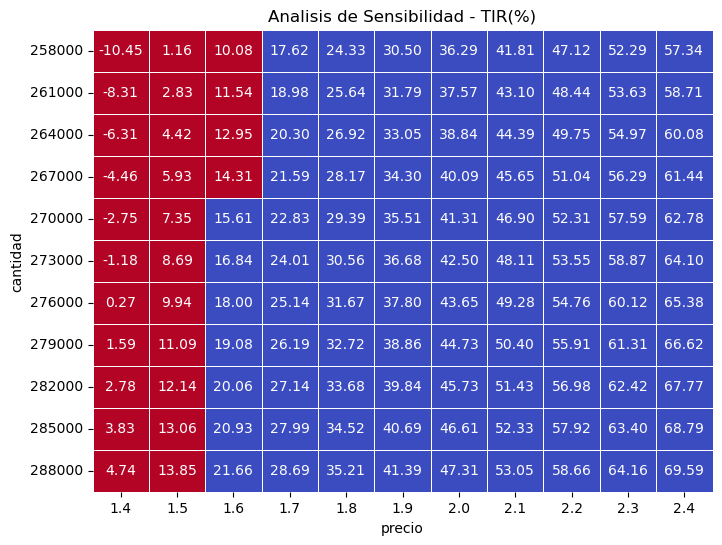

In [15]:
# Valores del precio
p_min=1.5
p_max=2.5
p_step = 0.1
price = np.round(generate_data(min_value = p_min, 
                               year_range = 10, 
                               step = p_step, 
                               year_0=p_min-p_step, 
                               max_value=p_max, 
                               is_quantity=True),2).tolist()

# Valores de cantidades
q_min=261000
q_max=288000
q_step = 3000
quantity = generate_data(min_value = q_min , 
                         year_range = 10, 
                         step = q_step, 
                         year_0=q_min-q_step, 
                         max_value=q_max, 
                         is_quantity=True)

# Funcion tabla analisis de sensibilidad, x = precios , y = cantidades
sensitivity_analysis(cok = 14.5, 
                     price = price , 
                     quantity = quantity, 
                     cost_product= 187184.96, 
                     cost_admin = 24852.90, 
                     x_axis = price, 
                     y_axis = quantity, 
                     x_name= "precio", 
                     y_name= "cantidad"
                    )

## Simulacion Monte Carlo

In [16]:
def monte_carlo(price,    # Valores distribucion precio.
                quantity, # Valores distribucion cantidad.
                cost_product, # Valores distribucion costo de produccion.
                cost_admin,   # Valores distribucion costo de  administracion.
                probability_tir=None, # Valor, la funcion retorno es la probabiblidad de superarlo.
                cok=None # % Costo oportunidad , de 0 a 100, la funcion retorna la probabilidad de superarlo.
               ):
    '''
    Retorna el histograma y su ajuste normal del TIR, junto con
    el Promedio, Desviacion estandar, Moda.
    Ademas de la probabilidad de superar el 'cok' y el 'probability_tir'
    '''
    
    # Funcion TIR_VAN_calculator
    TIR = [TIR_VAN_calculator(
                    price=p,
                    quantity=q,
                    cost_product=cp,
                    cost_admin=ca
                )
            for q,p,cp,ca in zip(quantity,price,cost_product,cost_admin)]

    # Moda de los valores del TIR
    moda=stat.mode(TIR)

    # Crear el histograma de los valores de TIR
    n, bins, patches = plt.hist(TIR, bins=60, density=True, color= 'silver', alpha=0.6)

    # Ajustar una distribución normal a los datos
    mu, std = norm.fit(TIR)

    # Calcular los valores de la distribución normal ajustada
    y = norm.pdf(bins, mu, std)

    # Confeccion el histograma y la distribución normal ajustada
    plt.plot(bins, y, 'b--', linewidth=2)

    # Agregar una sombra debajo de la curva de la distribución normal 
    # para resaltar la región del TIR mayor a 'probability_tir'
    if probability_tir != None:
        x = np.linspace(probability_tir, mu + 3 * std, 1000)
        plt.fill_between(x, norm.pdf(x, mu, std), color='green', alpha=0.3)
        prob_tir = 1- norm.cdf(probability_tir, loc=mu, scale=std)
        p1 = f'Probabilidad mayor a {probability_tir}: {prob_tir}'
        pass


    # Calcular la probabilidad de que el TIR sea mayor a 'cok'
    if cok != None:
        prob_cok = 1- norm.cdf(cok, loc=mu, scale=std)
        p2 = f'Probabilidad mayor a cok({cok}): {prob_cok}'
        pass


    # Calcular la probabilidad de que el TIR sea positivo.
    prob_positive = 1 - norm.cdf(0, loc=mu, scale=std)

    # Graficar el histograma y la distribucion normal
    plt.xlabel('TIR')
    plt.ylabel('Frecuencia')
    plt.title('Ajuste del TIR')


    plt.show()

    print("TIR:")
    print("Promedio:", mu)
    print("Desviación estándar:", std)
    print("Moda:", moda)
    if probability_tir != None: print(p1)
    if cok != None: print(p2) 

Prueba de la simulacion MonteCarlo.<br>
Se generan 5000 valores de manera aleatoria, utilizando una distribucion triangular.

In [ ]:
num = 5000

# Cantidad
q_random = [ random.triangular(258000, 288000, 270000) for i in range(num)]  

# Precio
p_random = [ random.triangular(1.65, 2.00, 1.80) for i in range(num)]

# Costo de Produccion
cp_random = [ random.triangular(187104.96, 187284.96, 187184.96) for i in range(num)] 

# Costo de Administracion
ca_random = [ random.triangular(24832.90, 24952.90, 24852.90) for i in range(num)]

# Funcion Simulacion MonteCarlo
monte_carlo(price =p_random , 
            quantity = q_random, 
            cost_product= cp_random, 
            cost_admin = ca_random,
            probability_tir=25.63, 
            cok=14.5)

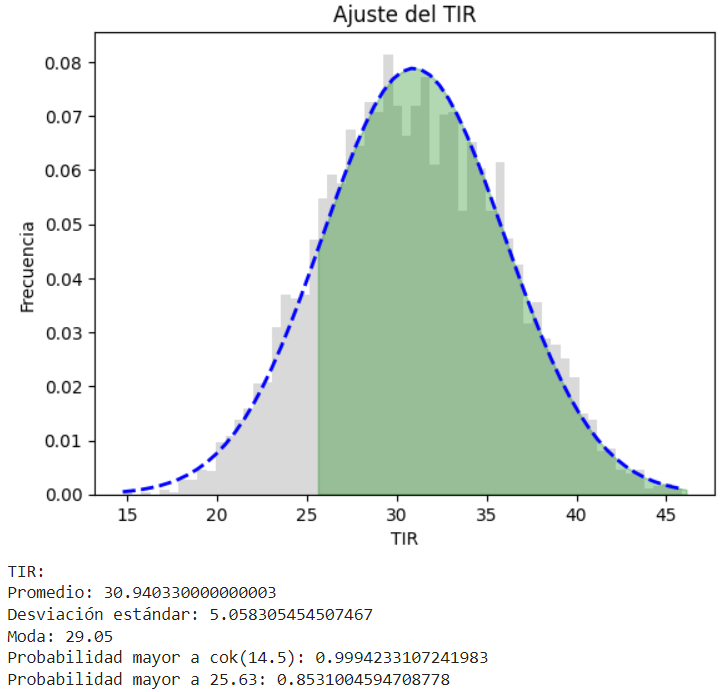